Use similar proposal for $\rho$.  
But the accept rate for $\rho$ is always small.  
The error of a and $\rho$ will decrease first and then increase.  
Decreasing $\sigma_g^2$ and $\sigma_{\rho}^2$ will reduce the error.

In [1]:
# import packages
import numpy as np
import seaborn as sns
from scipy.stats import wishart, dirichlet, expon, norm
import scipy.special as sc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

In [2]:
def para_x(u, s2, tao):
    lambdax = np.dot(s2.T, u).reshape(d,d)
    sx = np.linalg.inv(lambdax) # variance of x
    taox = np.dot(tao.T, u) # sum_j(u_j * tao_j)
    mux = np.dot(sx, taox) # mu(x)
    return sx, mux 
def document_generator(a, rho, T, s2, tao, N):
    '''
    Given the corpus, generate more documents.
    All corpus-level parameters are given.
    N: the number of documents.
    
    output: 
    X: N*d, X[i] = document[i]
    Y: Y[i] = label[i]
    G: membership
    U: transformed membership
    '''

    nlabel = len(T) # number of y
    d = len(tao[0]) # dim(x)
    
    Y = np.random.choice(list(range(nlabel)),N) # labels
    G = np.random.dirichlet(a*rho,N)
    U = np.array([np.dot(T[Y[i]], G[i]) for i in range(N)])

    X = []
    
    for i in range(N):
        sx, mux = para_x(U[i], s2, tao)
        X.append(np.random.multivariate_normal(mux, sx))
    X = np.array(X)

    return X, Y, G, U

def check_p(a, rho, mu, s_inv):
    '''
    Input: the parameters used in the data
    1. Check whether a and rho will generate extremely small g
    2. See distributions of different topics
    '''
    ntopic = len(mu)
    g = np.random.dirichlet(a*rho, 100)
#     print("The minimum component of g is",g.min())
    
    print("Distribution of pure types")
    s = [np.linalg.inv(i) for i in s_inv]
    pX = np.concatenate(tuple([np.random.multivariate_normal(mu[i], s[i], 100) for i in range(ntopic)]))
    pY = [[i]*100 for i in range(ntopic)]
    fig_pure_type = plt.figure()
    ax = Axes3D(fig_pure_type)
    ax.scatter(pX[:, 0], pX[:, 1], pX[:, 2], c = pY)
    plt.show()

In [3]:
def simplex_proposal(g, sigma):
    '''
    g is in simplex
    z[i] = log g[i]/g[-1]
    draw newz~N(z, sigma*I)
    newz -> newg
    '''
    z = np.log(g[:-1]/g[-1])
    newz = np.random.multivariate_normal(z, sigma*np.eye(len(z)))
    newg = np.exp(np.append(newz,0))
    newg /= newg.sum()
    return newg

def px(x, u, s2, tao):
    # return 0.5*log|lambda_x|-0.5(x-mux)^T*lambda_x*(x-mux)
    
    lambdax = np.dot(s2.T, u).reshape(d,d)
    sx = np.linalg.inv(lambdax) # variance of x
    taox = np.dot(tao.T, u) # sum_j(u_j * tao_j)
    mux = np.dot(sx, taox) # mu(x)
    
    return 0.5*np.log(np.linalg.det(lambdax))-0.5*np.dot(np.dot((x-mux).T, lambdax), x-mux)


def gibbs(X, Y, alpha, b, T, s2, tao, sigmaa, sigmarho, sigmag, nconverge, nskip, nsave, a):
    '''
    Input:
        Data: X and Y
        hyper(fixed): alpha, b
        para: T, s2, tao
        Tuning parameter: sigmaa, sigmarho, sigmag
        # For comparing: a, rho, G
        After nconverge times, start saving samples
        nskip:  block size for each saved state
        nsave: number of saved states
    
    Output:
        Gs, as, rhos: the saved states 
        arG, arrho, ara: accept rate list during every nskip iterations
        the length of all these variables = nsave + 1
    '''
    
    
    nlabel = len(T)
    dg = len(alpha)
    ntopic = len(T[0])
    d = len(X[0])
    N = len(Y)  
    
    infinity = 10**(-5) # To avoid overflow, if we get g or rho smaller than this
    
    
    # initialization
    rho1 = np.random.dirichlet(np.ones(dg), 1)[0]
    G1 = np.random.dirichlet(np.ones(dg), N)
#     a1 = np.random.exponential(1/b,1)[0]    
    a1 = a
    probx = [px(X[i], np.dot(T[Y[i]], G1[i]), s2, tao) for i in range(N)]
    
    asave, Gs, rhos, ara, arG, arrho = [], [], [], [], [], [] # estimates and accept rates
    ca = cg = crho = 0 # count of accepted proposals
    
    for t in range(nconverge):
        # update G
        for i in range(N):
            oldg = G1[i]
            newg = simplex_proposal(oldg, sigmag)
            if newg.min()<infinity: newg = (newg + infinity*np.ones(dg))/(1+infinity)
            newpx = px(X[i], np.dot(T[Y[i]], newg), s2, tao)
            oldp = ((a1*rho1-1)*np.log(oldg)).sum() + probx[i]
            newp = ((a1*rho1-1)*np.log(newg)).sum() + newpx
            
            ag = min(1, np.exp(min(1,newp-oldp))) # avoid overflow when newp>>oldp
            if np.random.uniform() < ag:
                G1[i] = newg # update G
                probx[i] = newpx # update px
                cg += 1
                
        logG = np.log(G1).sum(axis = 0) 
        
        # update rho
        newrho = simplex_proposal(rho1, sigmarho)
        if newrho.min()<infinity: newrho = (newrho + infinity*np.ones(dg))/(1+infinity)
        newp = ((alpha-1)*np.log(newrho)).sum() - N*(sc.loggamma(a1*newrho)).sum() + ((a1*newrho-1)*logG).sum()
        oldp = ((alpha-1)*np.log(rho1)).sum() - N*(sc.loggamma(a1*rho1)).sum() + ((a1*rho1-1)*logG).sum()
        arho = min(1, np.exp(min(1,newp-oldp)))
        if np.random.uniform() < arho:
            rho1 = newrho.copy()
            crho += 1
            
    asave.append(a1)
    Gs.append(G1.copy())
    rhos.append(rho1.copy())
    ara.append(ca/nconverge)
    arG.append(cg/nconverge/N)
    arrho.append(crho/nconverge)
    
    
    for step in range(nsave):
        ca = cg = crho = 0
        
        for t in range(nskip):
        # update G
            for i in range(N):
                oldg = G1[i]
                newg = simplex_proposal(oldg, sigmag)
                if newg.min()<infinity: newg = (newg + infinity*np.ones(dg))/(1+infinity)
                newpx = px(X[i], np.dot(T[Y[i]], newg), s2, tao)
                oldp = ((a1*rho1-1)*np.log(oldg)).sum() + probx[i]
                newp = ((a1*rho1-1)*np.log(newg)).sum() + newpx
                ag = min(1, np.exp(min(1,newp-oldp))) # avoid overflow when newp>>oldp
                if np.random.uniform() < ag:
                    G1[i] = newg # update G
                    probx[i] = newpx # update px
                    cg += 1
                    
        logG = np.log(G1).sum(axis = 0) 
        
        # update rho
        newrho = simplex_proposal(rho1, sigmarho)
        if newrho.min()<infinity: newrho = (newrho + infinity*np.ones(dg))/(1+infinity)
        newp = ((alpha-1)*np.log(newrho)).sum() - N*(sc.loggamma(a1*newrho)).sum() + ((a1*newrho-1)*logG).sum()
        oldp = ((alpha-1)*np.log(rho1)).sum() - N*(sc.loggamma(a1*rho1)).sum() + ((a1*rho1-1)*logG).sum()
        arho = min(1, np.exp(min(1,newp-oldp)))
        if np.random.uniform() < arho:
            rho1 = newrho.copy()
            crho += 1

        Gs.append(G1.copy())
        arG.append(cg/nskip/N)  
        rhos.append(rho1.copy())
        arrho.append(crho/nskip)
    
    return asave, Gs, rhos, ara, arG, arrho

the value of a: 15.8765530368073


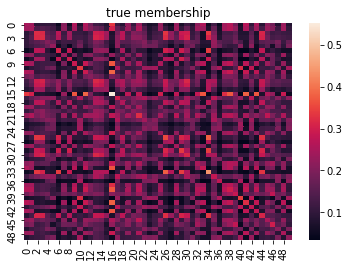

Distribution of pure types


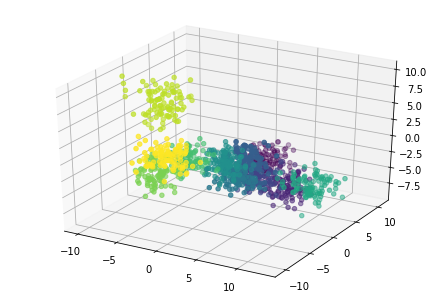

In [4]:
# set parameters
d = 30
k0, k1 = 2,5
nlabel = 3
alpha = np.ones(7)
b = 0.1
para_topic = [np.zeros(d),0.1,np.eye(d)/3/d, 3*d]
N, sigmaa, sigmarho, sigmag, nconverge, nskip, nsave =  50, 1,0.1,0.1,10, 10,500
# define T
dg = k0 + k1 
ntopic = nlabel*k0+k1
T = []
for i in range(nlabel):
    tem = np.block([
        [np.zeros((k0*i,k0+k1))],
        [np.eye(k0), np.zeros((k0, k1))],
        [np.zeros((k0*(nlabel-i-1),k0+k1))],
        [np.zeros((k1,k0)), np.eye(k1)]
    ])
    T.append(tem)
# draw corpus-level parameters
rho = np.random.dirichlet(alpha, 1)[0]
a = np.random.exponential(1/b,1)[0]

mu0, lambda0, W, nu = para_topic
d = len(mu0)
s_inv = wishart.rvs(df = nu, scale = W, size=ntopic) # sigma inverse
mu = np.array([np.random.multivariate_normal(mu0, 1/lambda0*np.linalg.inv(i)) for i in s_inv])    
s2 = np.array([i.flatten() for i in s_inv]) # flatten s_inv, s2[i].reshape(d,d) = s_inv[i]
tao = np.array([np.dot(s_inv[i], mu[i]) for i in range(ntopic)]) # sigma^-1 mu    
# generate data
X, Y, G, U = document_generator(a, rho, T, s2, tao, N)
print("the value of a:", a)
trueU = sns.heatmap(np.dot(U,U.T))
plt.title("true membership")
plt.show()
check_p(a, rho, mu, s_inv)

In [5]:
def tuningp(sigmarho, sigmag,nconverge, nskip, nsave,a):
    asave, Gs, rhos, ara, arG, arrho = gibbs(X, Y, alpha, b, T, s2, tao, 1, sigmarho, sigmag, nconverge, nskip, nsave,a)
    nsave = len(Gs)-1
    nskip = 10
    print("accept rate of a, G and rho for the last iteration:",arG[-1], arrho[-1])
    G1 = Gs[-1]
    print("ave error G:", (abs(G-G1)).sum()/N)
    print("error rho:", abs(rhos[-1]-rho).sum())

    differenceG = abs(G-G1).sum(axis=1)
    error_summary_G = []
    print("\n")
    for tt in range(5,0,-1):
        tem = tt/10
        error_summary_G.append(sum([1 for i in range(N) if differenceG[i]<tem])/50)
        print("P(difference<"+str(tem)+")=", error_summary_G[-1])

    eU = sns.heatmap(np.dot(G1,G1.T))
    plt.title("estimated membership")
    plt.show()

    errorG = abs(Gs - G).sum(axis=1).sum(axis=1)/N
    plt.scatter([i*nskip for i in range(nsave+1)], errorG, s=5)
    plt.title("estimation error of G")
    plt.xlabel("t")
    plt.ylabel("error")
    plt.show()

    plt.scatter([i*nskip for i in range(nsave+1)], arG, s=5)
    plt.title("acc rate of G")
    plt.xlabel("t")
    plt.ylabel("error")
    plt.show()

    errorrho = abs(rhos - rho).sum(axis=1)
    plt.scatter([i*nskip for i in range(nsave+1)], errorrho, s=5)
    plt.title("estimation error of rho")
    plt.xlabel("t")
    plt.ylabel("error")
    plt.show()

    plt.scatter([i*nskip for i in range(nsave+1)], arrho, s=5)
    plt.title("acc rate of rho")
    plt.xlabel("t")
    plt.ylabel("error")
    plt.show()



accept rate of a, G and rho for the last iteration: 0.32 0.0
ave error G: 0.44828619647650475
error rho: 0.7200559676423668


P(difference<0.5)= 0.6
P(difference<0.4)= 0.42
P(difference<0.3)= 0.3
P(difference<0.2)= 0.06
P(difference<0.1)= 0.0


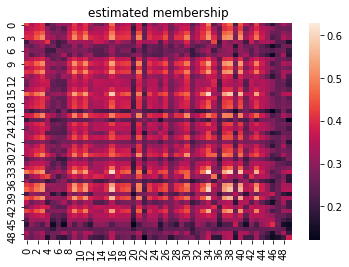

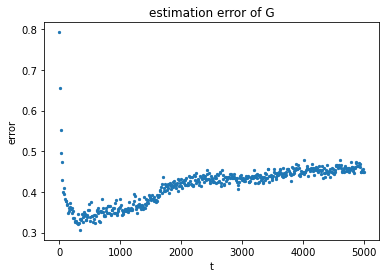

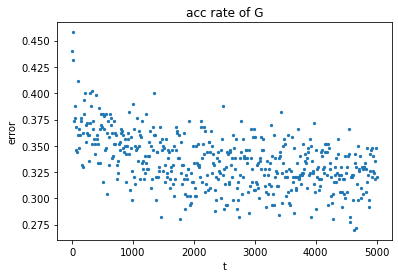

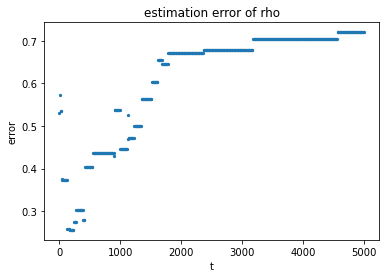

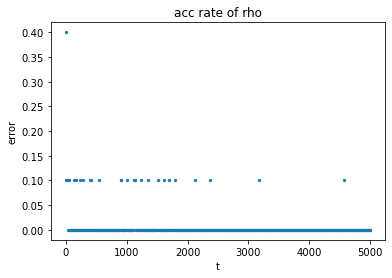

In [6]:
tuningp(sigmarho=0.1, sigmag=0.1,nconverge=10, nskip=10, nsave=500,a=a)

accept rate of a, G and rho for the last iteration: 0.716 0.0
ave error G: 0.386266641872343
error rho: 0.39044846668878236


P(difference<0.5)= 0.76
P(difference<0.4)= 0.58
P(difference<0.3)= 0.36
P(difference<0.2)= 0.1
P(difference<0.1)= 0.0


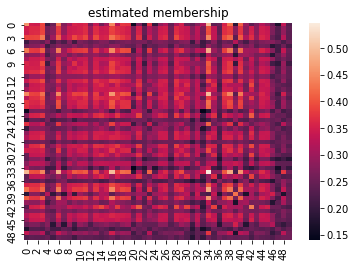

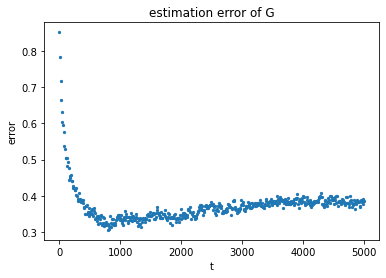

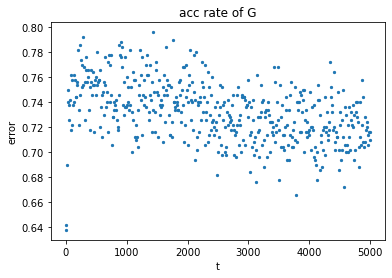

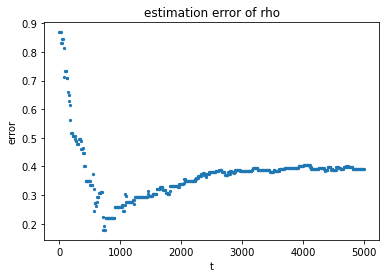

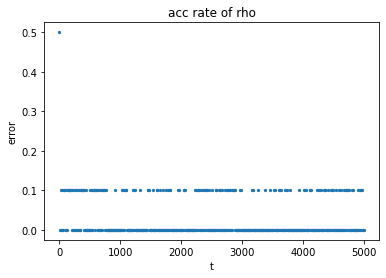

In [7]:
tuningp(sigmarho=0.01, sigmag=0.01,nconverge=10, nskip=10, nsave=500,a=a)

accept rate of a, G and rho for the last iteration: 0.7340000000000001 0.0
ave error G: 0.40169115704571046
error rho: 0.5323579322357348


P(difference<0.5)= 0.72
P(difference<0.4)= 0.54
P(difference<0.3)= 0.34
P(difference<0.2)= 0.1
P(difference<0.1)= 0.0


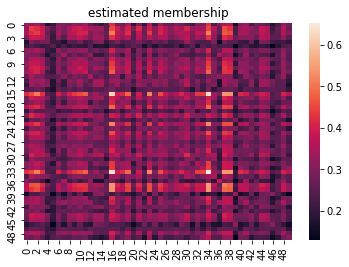

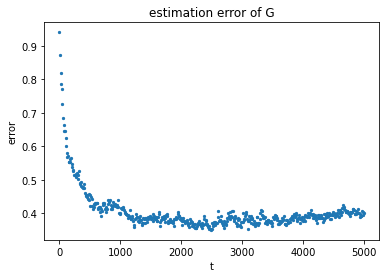

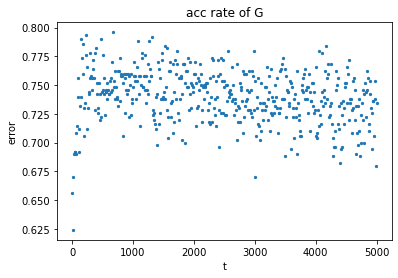

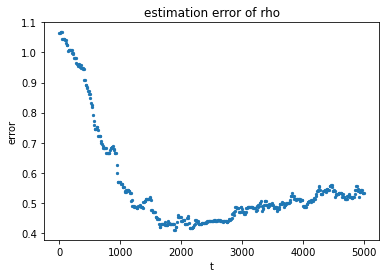

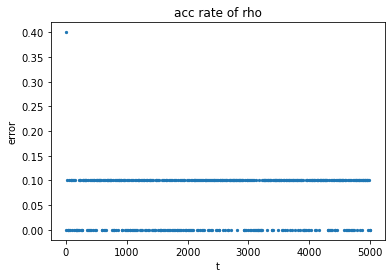

In [8]:
tuningp(sigmarho=0.001, sigmag=0.01,nconverge=10, nskip=10, nsave=500,a=a)

accept rate of a, G and rho for the last iteration: 0.746 0.1
ave error G: 0.3368726865865842
error rho: 0.3927760905009475


P(difference<0.5)= 0.9
P(difference<0.4)= 0.7
P(difference<0.3)= 0.4
P(difference<0.2)= 0.18
P(difference<0.1)= 0.0


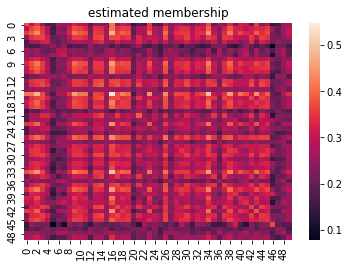

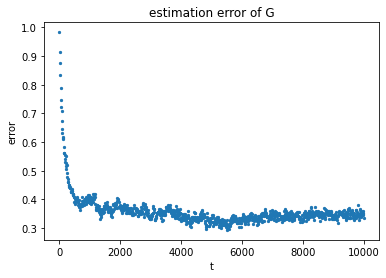

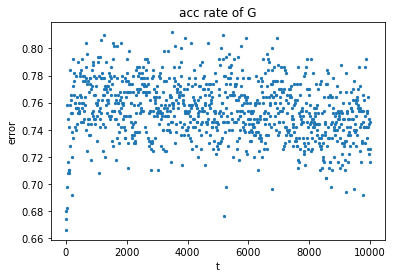

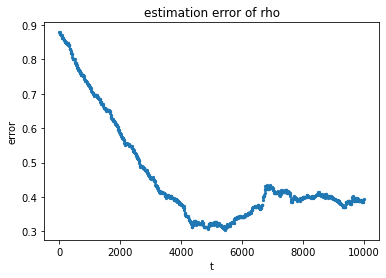

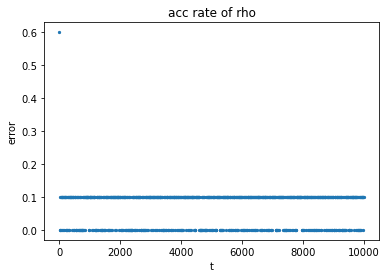

In [10]:
tuningp(sigmarho=0.0001, sigmag=0.01,nconverge=10, nskip=10, nsave=1000,a=a)

accept rate of a, G and rho for the last iteration: 0.92 0.0
ave error G: 0.3801087902521505
error rho: 0.40825693210832925


P(difference<0.5)= 0.8
P(difference<0.4)= 0.56
P(difference<0.3)= 0.38
P(difference<0.2)= 0.08
P(difference<0.1)= 0.0


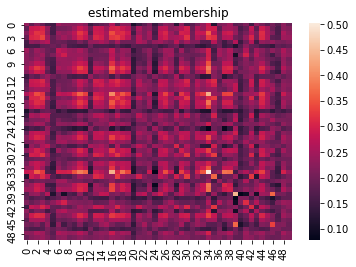

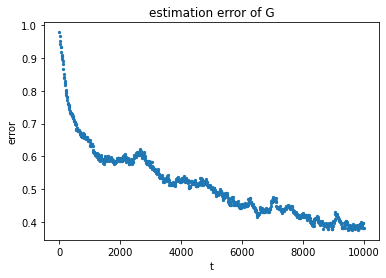

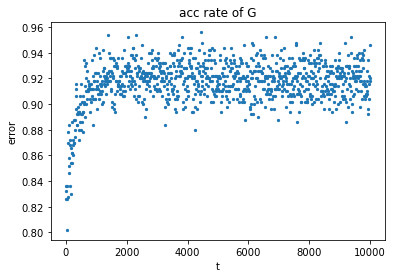

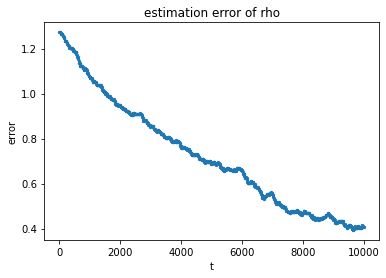

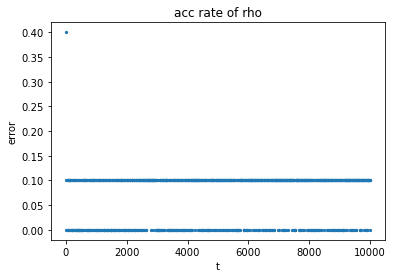

In [12]:
tuningp(sigmarho=0.0001, sigmag=0.001,nconverge=10, nskip=10, nsave=1000,a=a)
# converges too slow